In [ ]:
from Dataset import DatasetBuilder

start_directory = "C:\\Users\\gciprianherrera\\Desktop\\LLM\\MVP_Chatbot\\PDF"
pdf_processor = DatasetBuilder(start_directory)
data = pdf_processor.process_directory()

In [3]:
import os
from langchain_openai import AzureChatOpenAI
from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_openai import AzureOpenAIEmbeddings

In [4]:
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_VERSION"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    model=os.getenv("AZURE_OPENAI_MODEL"),
    temperature=0,
)

In [3]:
embeddings: AzureOpenAIEmbeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("AZURE_OPENAI_EMB_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_EMB_API_KEY"),
    openai_api_version=os.getenv("AZURE_OPENAI_EMB_VERSION"),
    azure_deployment=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT_NAME"),
)

In [6]:
index_name: str = "complete_dataset"
vector_store: AzureSearch = AzureSearch(
    azure_search_key = os.getenv("AZURE_AI_SEARCH_API_KEY"),
    azure_search_endpoint = os.getenv("AZURE_AI_SEARCH_ENDPOINT"),
    index_name=index_name,
    embedding_function=embeddings.embed_query
)

In [7]:
import pandas as pd
from langchain_community.document_loaders import DataFrameLoader

loader = DataFrameLoader(data, page_content_column="page_content")
documents = loader.load()

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')
def tiktoken_len(text):
    tokens = tokenizer.encode(text, disallowed_special=())
    return len(tokens)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=5,
    length_function=tiktoken_len,
    separators=["\n", " ", ""])
splits = text_splitter.split_documents(documents)
vector_store.add_documents(documents=splits)

In [9]:
AZURE_AI_SEARCH_API_KEY=os.getenv("AZURE_AI_SEARCH_API_KEY")
AZURE_AI_SEARCH_ENDPOINT=os.getenv("AZURE_AI_SEARCH_ENDPOINT")
AZURE_AI_SEARCH_DEPLOYEMENT_ID=os.getenv("AZURE_AI_SEARCH_DEPLOYEMENT_ID")
AZURE_AI_SEARCH_INDEX_NAME=os.getenv("AZURE_AI_SEARCH_INDEX_NAME")
AZURE_AI_SEARCH_SERVICE_NAME=os.getenv("AZURE_AI_SEARCH_SERVICE_NAME")

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
import os
from langchain_openai import AzureChatOpenAI
from langchain_community.retrievers import AzureAISearchRetriever

llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2023-05-15",
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    model="gpt-35-turbo",
    temperature=0,
)

index_name: str = "complete_dataset"
retriever = AzureAISearchRetriever(
    content_key="content", top_k=30, index_name=index_name
)

# query = "Quel est l'objectif du compte-rendu de la cellule 951 DEG"  
# query = "Quel est l'objectif de l'investigation sur l’ensemble porte-lame cellule 904"  
# query = "Quels sont les équipements investigués sur le périmètre DEG"  
# query = "Quel est le débit de dose de la 951 du DEG " 
# query = "Quelles sont les informations de la cellule 909 du DEG " 
# query = "Quelle est la quantité de boue de la fosse 217-02 du DEG"  
# query = "DDD des PE de boues sur la fosse 217-02 du DEG " 
query = "Quels sont les enseignements sur les investigations de la cellule 959B du HADE"
# query = "Quelles sont les informations sur l'état de la cellule 929A du périmètre HADE"

system_prompt = (
    "Use the given context to answer the question. "
    "If you don't know the answer, say you don't know. "
    "Use five sentence maximum and keep the answer concise. "
    "Context: {context}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, prompt)
chain = create_retrieval_chain(retriever, question_answer_chain)
result = chain.invoke({"input": query})



import json
from collections import OrderedDict

def extract_list_sources(result):
    sources = []
    for doc in result['context']:
        try:
            data = doc.metadata['metadata']
            data = json.loads(data)
            source = data.get('Source')
            if source:
                sources.append(source)
        except json.JSONDecodeError:
            # Handle the case where metadata is not a valid JSON
            continue
    sources = list(OrderedDict.fromkeys(sources))
    return sources


# Creating JSON data
json_result = {
    "input": result['input'],
    "sources": extract_list_sources(result),
    "answer": result['answer']
}

In [102]:
import json
from collections import OrderedDict

def extract_list_sources(result):
    sources = []
    for doc in result['context']:
        try:
            data = doc.metadata['metadata']
            data = json.loads(data)
            source = data.get('Source')
            if source:
                sources.append(source)
        except json.JSONDecodeError:
            # Handle the case where metadata is not a valid JSON
            continue
    sources = list(OrderedDict.fromkeys(sources))
    return sources

In [1]:
import json
from collections import OrderedDict
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
import os
from langchain_community.retrievers import AzureAISearchRetriever


class Chatbot:
    def __init__(self):
        self.llm = AzureChatOpenAI(
            azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
            api_key=os.getenv("AZURE_OPENAI_API_KEY"),
            api_version="2023-05-15",
            azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
            model="gpt-35-turbo",
            temperature=0,
        )

        self.index_name = "complete_dataset"
        self.retriever = AzureAISearchRetriever(
            content_key="content", top_k=30, index_name=self.index_name
        )

        system_prompt = (
            "Use the given context to answer the question. "
            "If you don't know the answer, say you don't know. "
            "Use five sentences maximum and keep the answer concise. "
            "Context: {context}"
        )
        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("human", "{input}"),
            ]
        )
        self.question_answer_chain = create_stuff_documents_chain(self.llm, prompt)
        self.chain = create_retrieval_chain(self.retriever, self.question_answer_chain)

    def ask(self, user_query):
        result = self.chain.invoke({"input": user_query})
        
        def extract_list_sources(result):
                sources = []
                for doc in result['context']:
                    try:
                        data = doc.metadata['metadata']
                        data = json.loads(data)
                        source = data.get('Source')
                        if source:
                            sources.append(source)
                    except json.JSONDecodeError:
                        # Handle the case where metadata is not a valid JSON
                        continue
                sources = list(OrderedDict.fromkeys(sources))  # Remove duplicates while preserving order
                return sources
        
        # Create the json_result
        json_result = {
            "input": result['input'],
            "sources": extract_list_sources(result),
            "answer": result['answer']
        }
    
        return json_result

In [ ]:
from chat import Chatbot

chatbot = Chatbot()
# query = "Quel est l'objectif du compte-rendu de la cellule 951 DEG"  
# query = "Quel est l'objectif de l'investigation sur l’ensemble porte-lame cellule 904"  
# query = "Quels sont les équipements investigués sur le périmètre DEG"  
# query = "Quel est le débit de dose de la 951 du DEG " 
# query = "Quelles sont les informations de la cellule 909 du DEG " 
# query = "Quelle est la quantité de boue de la fosse 217-02 du DEG"  
# query = "DDD des PE de boues sur la fosse 217-02 du DEG " 
# query = "Quels sont les enseignements sur les investigations de la cellule 959B du HADE"
query = "Quelles sont les informations sur l'état de la cellule 929A du périmètre HADE"
response = chatbot.ask(query)

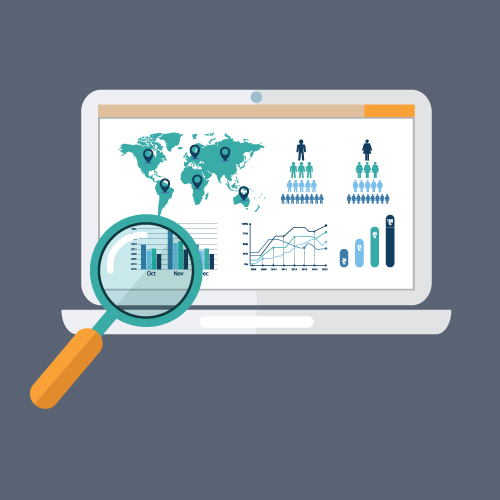

In [4]:
# create a list of images

from IPython.display import Image, display

images = ['data1.jpg', 'data2.jpg']
display(Image(images[0]))

In [39]:
import os
import base64

def encode_images_in_folder_to_base64(folder_path):
    base64_strings = []
    
    # List all files in the folder
    for filename in os.listdir(folder_path):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Ensure the file is an image (you can add more image extensions if needed)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            with open(file_path, 'rb') as image_file:
                image_data = image_file.read()
            base64_encoded_data = base64.b64encode(image_data)
            base64_string = base64_encoded_data.decode('utf-8')
            base64_strings.append(base64_string)
    
    return base64_strings

# Example usage:
folder_path = 'C:\\Users\\gciprianherrera\\Desktop\\OranoDS\\Chatbot-Orano-DS\\test_img'
encoded_images = encode_images_in_folder_to_base64(folder_path)

# Print the results
for encoded_image in encoded_images:
    print(encoded_image)


/9j/4AAQSkZJRgABAgAAZABkAAD/7AARRHVja3kAAQAEAAAAZAAA/+4ADkFkb2JlAGTAAAAAAf/bAIQAAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQICAgICAgICAgICAwMDAwMDAwMDAwEBAQEBAQECAQECAgIBAgIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMD/8AAEQgB9AH0AwERAAIRAQMRAf/EAPcAAQACAwEBAQEBAQAAAAAAAAAICQYHCgUEAwILAQEBAAEEAwEBAAAAAAAAAAAAAAYDBAUHAQIICQoQAAAGAgEBAgcIDAgHDAcJAQABAgMEBQYHCBESEyEUFZbWVwkxItO1FheXGUEjM9RVlVZ2dxg4WFFhMpQ2tjeHQiRU1beYCtFSktJTk7QlNSbXOXGBckRneKiRorJzNHVGJ6fYEQABAwIDAggJCAQKBwgBBQABAAIDEQQhEgUxBkFR0SKSExQHYXGBkaEyUlMVsUJyIzPTFgjB4TQX8GKy0nOTsyRVNoKidNQ1NxjxY6NUlLQldUPC4sNlJv/aAAwDAQACEQMRAD8AgiNoKIICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICICIC

In [40]:
string_images = encoded_images

In [45]:

from PIL import Image
from io import BytesIO


# Decode the Base64 string
image_data = base64.b64decode(string_images[1])
# Convert the bytes data to an image
image = Image.open(BytesIO(image_data))

# Display the image
image.show()

In [1]:


import fitz  # PyMuPDF
import io
from PIL import Image

# Open the PDF file
pdf_file = fitz.open("C:\\Users\\gciprianherrera\\Desktop\\OranoDS\\Chatbot-Orano-DS\\PDF\\DEG\\ELH-2018-022986.pdf")

# Iterate over PDF pages
for page_index in range(len(pdf_file)):
    page = pdf_file[page_index]
    image_list = page.get_images(full=True)

    # # Print the number of images found on this page
    # if image_list:
    #     print(f"[+] Found a total of {len(image_list)} images in page {page_index}")
    # else:
    #     print(f"[!] No images found on page {page_index}")

    # for image_index, img in enumerate(image_list, start=1):
    #     xref = img[0]
    #     base_image = pdf_file.extract_image(xref)
    #     image_bytes = base_image["image"]
    #     image_ext = base_image["ext"]
    #     image = Image.open(io.BytesIO(image_bytes))

    #     # create a folder with the name of the pdf file and save the images in this folder
    #     folder_name = pdf_file.name.split("\\")[-1].split(".")[0]
    #     if not os.path.exists(folder_name):
    #         os.makedirs(folder_name)
    #         image.save(f"{folder_name}/image_{image_index}.{image_ext}")
    
    
    image_list

In [ ]:
import os
import base64

def encode_images_in_folder_to_base64(folder_path):
    base64_strings = []
    
    # List all files in the folder
    for filename in os.listdir(folder_path):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Ensure the file is an image (you can add more image extensions if needed)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            with open(file_path, 'rb') as image_file:
                image_data = image_file.read()
            base64_encoded_data = base64.b64encode(image_data)
            base64_string = base64_encoded_data.decode('utf-8')
            base64_strings.append(base64_string)
            
            # Delete the image file after encoding
            os.remove(file_path)
    
    return base64_strings

# Example usage:
folder_path = 'path/to/your/folder'
encoded_images = encode_images_in_folder_to_base64(folder_path)

# Print the results
for encoded_image in encoded_images:
    print(encoded_image)


In [5]:
import fitz  # PyMuPDF
import base64

source = "C:\\Users\\gciprianherrera\\Desktop\\OranoDS\\Chatbot-Orano-DS\\PDF\\DEG\\ELH-2018-022986.pdf"

pdf_file = fitz.open(source)

# Iterate over PDF pages

base64_strings_img = []

for page_index in range(len(pdf_file)):
    page = pdf_file[page_index]
    image_list = page.get_images(full=True)
    
    for image_index, img in enumerate(image_list, start=1):
        xref = img[0]
        base_image = pdf_file.extract_image(xref)
        image_bytes = base_image["image"]
        base64_string = base64.b64encode(image_bytes).decode('utf-8')
        base64_strings_img.append(base64_string)
        base64_strings_img = list(set(base64_strings_img))
        

In [ ]:
import base64
import fitz  # PyMuPDF

source = "C:\\Users\\gciprianherrera\\Desktop\\OranoDS\\Chatbot-Orano-DS\\PDF\\DEG\\ELH-2018-022986.pdf"

def extract_images_from_pdf_to_base64(pdf_path):
    base64_strings_img = []

    # Open the PDF file
    pdf_file = fitz.open(pdf_path)
    
    # Iterate over each page in the PDF
    for page_index in range(len(pdf_file)):
        page = pdf_file[page_index]
        image_list = page.get_images(full=True)
        
        # Iterate over each image in the page
        for image_index, img in enumerate(image_list, start=1):
            xref = img[0]
            base_image = pdf_file.extract_image(xref)
            image_bytes = base_image["image"]
            
            # Encode the image bytes to base64
            base64_string = base64.b64encode(image_bytes).decode('utf-8')
            base64_strings_img.append(base64_string)
    
    # Remove duplicate base64 strings
    base64_strings_img = list(set(base64_strings_img))
    
    return base64_strings_img

extract_images_from_pdf_to_base64(source)

In [1]:
import base64
from PIL import Image
from io import BytesIO

image_data = base64.b64decode("iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAAAAAA6mKC9AAAACXBIWXMAAA7EAAAOxAGVKw4bAAAAIklEQVR4nGNg+I8BGVBoBqzy6BgbRMiTZwY13MGAYg5hMwBsqWWb4UkgTwAAAABJRU5ErkJggg==")
# Convert the bytes data to an image
image = Image.open(BytesIO(image_data))
# Display the image
image.show()

In [ ]:
import base64
from PIL import Image
from io import BytesIO

def decode_and_display_images(base64_strings):
    for base64_string in base64_strings:
        # Decode the Base64 string
        image_data = base64.b64decode(base64_string)
        # Convert the bytes data to an image
        image = Image.open(BytesIO(image_data))
        # Display the image
        image.show()

# Call the function to decode and display the images
decode_and_display_images(base64_strings_list)


In [2]:
from Document import Document
source = "C:\\Users\\gciprianherrera\\Desktop\\OranoDS\\Chatbot-Orano-DS\\PDF\\DEG\\ELH-2018-022986.pdf"
doc = Document(source)
data = doc.process_document()

In [1]:
from PIL import Image
import io
import base64
from IPython.display import display, HTML

def display_images(base64_strings):
    images_html = ""
    for base64_string in base64_strings:
        # Decode the base64 string to get image bytes
        image_data = base64.b64decode(base64_string)
        # Convert bytes data to an image
        image = Image.open(io.BytesIO(image_data))
        # Convert image to HTML format
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        images_html += f'<img src="data:image/png;base64,{img_str}" style="margin:10px; display:inline-block; border:1px solid #ddd; padding:5px;"/>'
    
    display(HTML(images_html))

# Example usage:
# Assuming you have a list of base64-encoded strings
base64_strings = [
    # Add your base64 encoded image strings here
]

# display_images(data["metadata"]["images_base64"])

In [7]:
import fitz  # PyMuPDF

def extract_images_from_pdf_to_list(pdf_path):
    # List to store the images
    images_list = []

    # Open the PDF file
    pdf_document = fitz.open(pdf_path)
    
    # Iterate through each page
    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        image_list = page.get_images(full=True)
        
        # Print the number of images found on this page
        # print(f"Page {page_number + 1} has {len(image_list)} images.")
        
        for img_index, img in enumerate(image_list, start=1):
            xref = img[0]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            image_extension = base_image["ext"]
            
            # Append the image data and extension to the list
            images_list.append(base_image)
            # images_list.append({"page": page_number + 1, "index": img_index, "image_bytes": image_bytes, "extension": image_extension})

            # print(f"Extracted image {img_index} from page {page_number + 1}.")

    return images_list

# Example usage
images = extract_images_from_pdf_to_list(source)

# The images list now contains all the images extracted from the PDF
# print(f"Extracted a total of {len(images)} images.")

extract_images_from_pdf_to_list(source)